## Task 1 - Optimal Transport in 1D

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from cycler import cycler
from matplotlib import rcParams, rcParamsDefault
from matplotlib.cm import get_cmap
from math import sqrt
from scipy.stats import wasserstein_distance
from matplotlib import colormaps

### Set Normal Distributions

In [3]:
mu_1, sigma_1 = 25, 5 # mean and standard deviation
mu_2, sigma_2 = 100, 10 # mean and standard deviation
num_samples = 10000 # num samples

# Distribution 1
x_1 = np.random.normal(mu_1, sigma_1, num_samples)
y_1 = stats.norm.pdf(x_1, mu_1, sigma_1)
x_1, y_1 = zip(*sorted(zip(x_1, y_1)))
x_1, y_1 = np.asarray(x_1), np.asarray(y_1)


# Distribution 2
x_2 = np.random.normal(mu_2, sigma_2, num_samples)
y_2 = stats.norm.pdf(x_2, mu_2, sigma_2)
x_2, y_2 = zip(*sorted(zip(x_2, y_2)))
x_2, y_2 = np.asarray(x_2), np.asarray(y_2)


### 2-Wasserstein distance calculation (closed-form vs. sampled)

In [4]:
# Closed form 2-Wasserstein:
closed_Wasserstein = abs(mu_1-mu_2) +  (sigma_1 + sigma_2 - 2 * sqrt(sigma_2*sigma_1))

# Sampled 2-Wasserstein
x_distances = x_2 - x_1
sampled_Wasserstein = np.average(x_distances)

print("Closed form solution:                " + str(closed_Wasserstein))
print("Sampled solution:                    " + str(sampled_Wasserstein))
print("SciPy wasserstein_distance function: " + str(wasserstein_distance(x_1, x_2)))

Closed form solution:                75.85786437626905
Sampled solution:                    75.01962908955309
SciPy wasserstein_distance function: 75.01962908955309


We can see that the closed form solution and the sampled solution are very similar.

### Plot Distributions

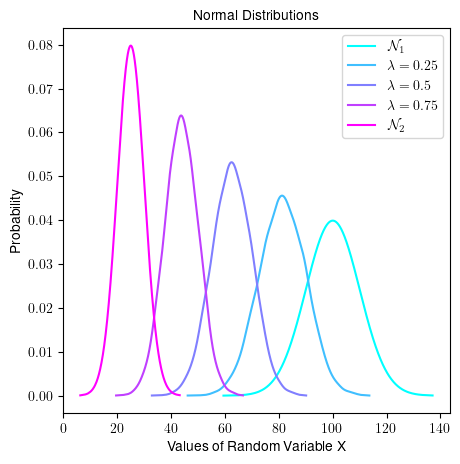

In [5]:
plt.figure(figsize=(5,5))

# Lambdas
lambdas = np.array([0.25, 0.5, 0.75])

# Set colormap
cmap = colormaps['cool']
colors = np.array(list(map(cmap, np.linspace(0.0, 1.0, (lambdas.size + 2)))))

rcParams['axes.prop_cycle'] = cycler(color=colors)

# Allow latex
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.plot(x_2, y_2, label= "$\mathcal{N}_1$")
# Generate and plot interpolated samples alongside distributions 1 and 2
for lamb in lambdas:
    z = lamb * x_1 + (1.0-lamb) * x_2
    kde = stats.gaussian_kde(z)
    plt.plot(z, kde(z), label= "$\lambda={}$".format(lamb))

plt.plot(x_1, y_1, label= "$\mathcal{N}_2$")
plt.title('Normal Distributions', fontsize='10')
plt.xlabel('Values of Random Variable X', fontsize='10')
plt.ylabel('Probability', fontsize='10')
plt.legend()
plt.show()

## Task 2

In [7]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# read the images and normalize
src_img = cv2.imread('src.png')
src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
src_img = src_img.astype(np.float32) / 255.0
dst_img = cv2.imread('dst.png')
dst_img = cv2.cvtColor(dst_img, cv2.COLOR_BGR2RGB)
dst_img = dst_img.astype(np.float32) / 255.0

In [9]:
def downsample_image(img, k):
    # calculate the new dimensions of the downsampled image
    new_width = int(img.shape[1] / k)
    new_height = int(img.shape[0] / k)

    # downsample the image using cv2.resize()
    downsampled_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    return downsampled_img

In [10]:
#downsampled_src_img = downsample_image(src_img, 4)
#downsampled_dst_img = downsample_image(dst_img, 4)
downsampled_src_img = src_img
downsampled_dst_img = dst_img

In [11]:
# Save original for comparison
original_downsampled_src_img = np.copy(downsampled_src_img)

In [12]:
def show_two_images(img1, img2):
    # plot the images
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
    ax1.imshow(img1)
    ax2.imshow(img2)

    plt.show()

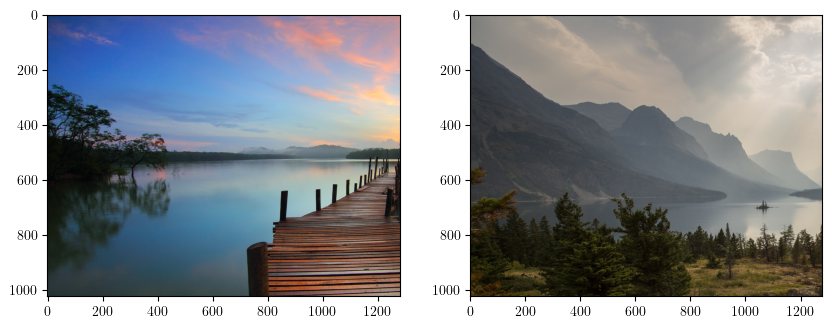

In [13]:
show_two_images(downsampled_src_img, downsampled_dst_img)

In [14]:
def plot_color_distribution_dual(img1, img2):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': '3d'})

    # Plot the pixel colors as individual points in a 3D scatter plot for img1
    ax1.scatter(img1[:,:,2], img1[:,:,1], img1[:,:,0], s=0.5)

    # Plot the pixel colors as individual points in a 3D scatter plot for img2
    ax2.scatter(img2[:,:,2], img2[:,:,1], img2[:,:,0], s=0.5)

    # Show the plots

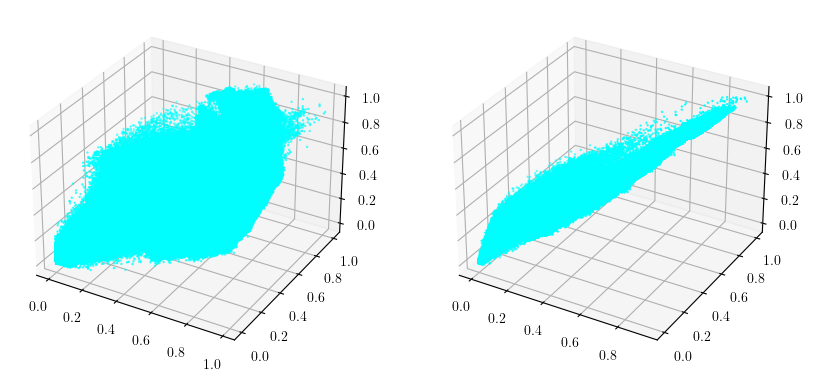

In [15]:
plot_color_distribution_dual(downsampled_src_img, downsampled_dst_img)

In [16]:
# Reshape to 3D
downsampled_src_img = downsampled_src_img.reshape(-1,3)
downsampled_dst_img = downsampled_dst_img.reshape(-1,3)

In [17]:
# generate a random normalized 3D vector
def random_normalized_vector_3d():
    # -1 to 1 interval?
    random_vec = (2 * np.random.random(3) - 1.0)  
    norm = np.linalg.norm(random_vec)
    if norm == 0:
        return np.random.rand(3)
    else:
        return random_vec / norm

In [18]:
def get_update(random_vec):
    # Project onto random vector
    projection_src = downsampled_src_img.dot(random_vec)
    projection_dst = downsampled_dst_img.dot(random_vec)

    indices = np.argsort(projection_src)
    sorted_projection_src = np.sort(projection_src)
    sorted_projection_dst = np.sort(projection_dst)
    distances = sorted_projection_dst - sorted_projection_src
    np.put(distances, indices, distances)
    return distances[:, np.newaxis]

In [19]:
num_iters = 100
num_directions = 10
for i in range(num_iters):
    update = np.zeros_like(downsampled_src_img)
    for j in range(num_directions):
        random_vec = random_normalized_vector_3d()
        update += get_update(random_vec) * random_vec
    downsampled_src_img += update / num_directions  
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


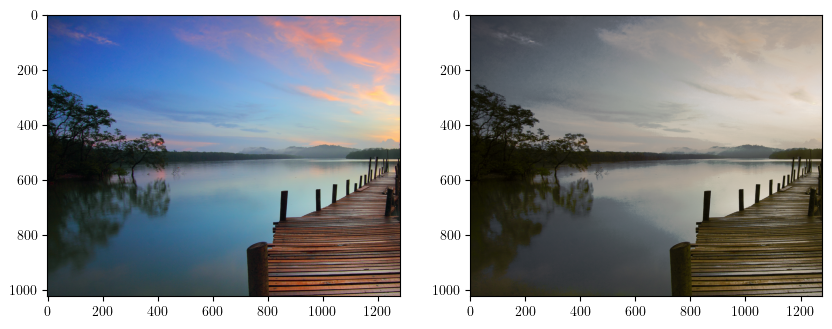

In [20]:
show_two_images(original_downsampled_src_img, downsampled_src_img.reshape(1024, 1280, 3))

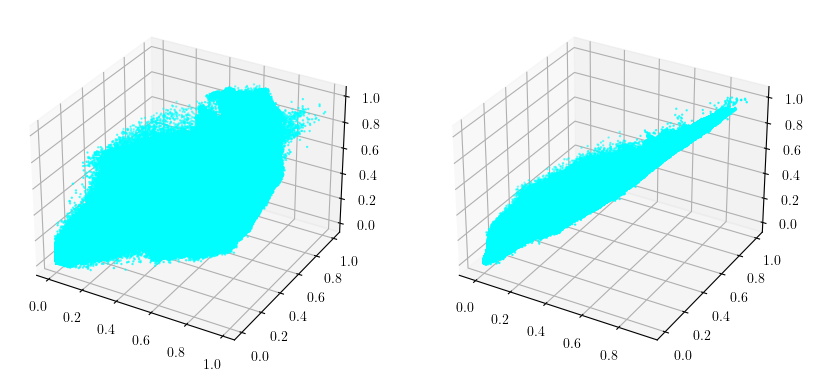

In [21]:
plot_color_distribution_dual(original_downsampled_src_img, downsampled_src_img.reshape(1024, 1280, 3))